/var/folders/vt/cs8060s55sngq2jtqtwhk1yc0000gn/T/ipykernel_74425/3411094749.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resampled_df[features_to_scale] = scaler.fit_transform(resampled_df[features_to_scale])


[[[0.23243743 0.21834941 0.46855855 0.54356612]
  [0.20607533 0.27703673 0.51122124 0.3685728 ]
  [0.23228096 0.21976865 0.83241545 0.38987666]
  [0.2695012  0.16522367 0.88969257 0.26212938]
  [0.212003   0.0821059  0.49283218 0.60644603]]

 [[0.67600189 0.18883467 0.47337418 0.45362806]
  [0.5584605  0.1888659  0.49930196 0.63586683]
  [0.36039618 0.20251778 0.44672773 0.50371616]
  [0.31029065 0.21251348 0.43325872 0.22585296]
  [0.30806121 0.31395234 0.36527565 0.43167832]]

 [[0.33855957 0.33378609 0.71866164 0.        ]
  [0.32788559 0.33002695 0.62912452 0.2060565 ]
  [0.30044825 0.25018799 0.77889922 0.39564312]
  [0.30797046 0.19157469 0.79282189 0.39744959]
  [0.46200343 0.05674084 0.41075237 1.        ]]

 [[0.61261179 1.         0.75934952 0.06163425]
  [0.62035529 0.99212812 0.87726486 0.14452877]
  [0.67259874 0.96549293 0.36731196 0.52485321]
  [0.75777385 0.89205622 0.76362835 0.86213721]
  [0.74966774 0.81847752 0.71925264 0.1402095 ]]

 [[0.34001964 0.35504853 0.16769

/Users/siri2001/IdeaProjects/Python2023/venv/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 210ms/step
Mean Squared Error: 0.06841331417130014
Mean Absolute Error: 0.23307496364298216


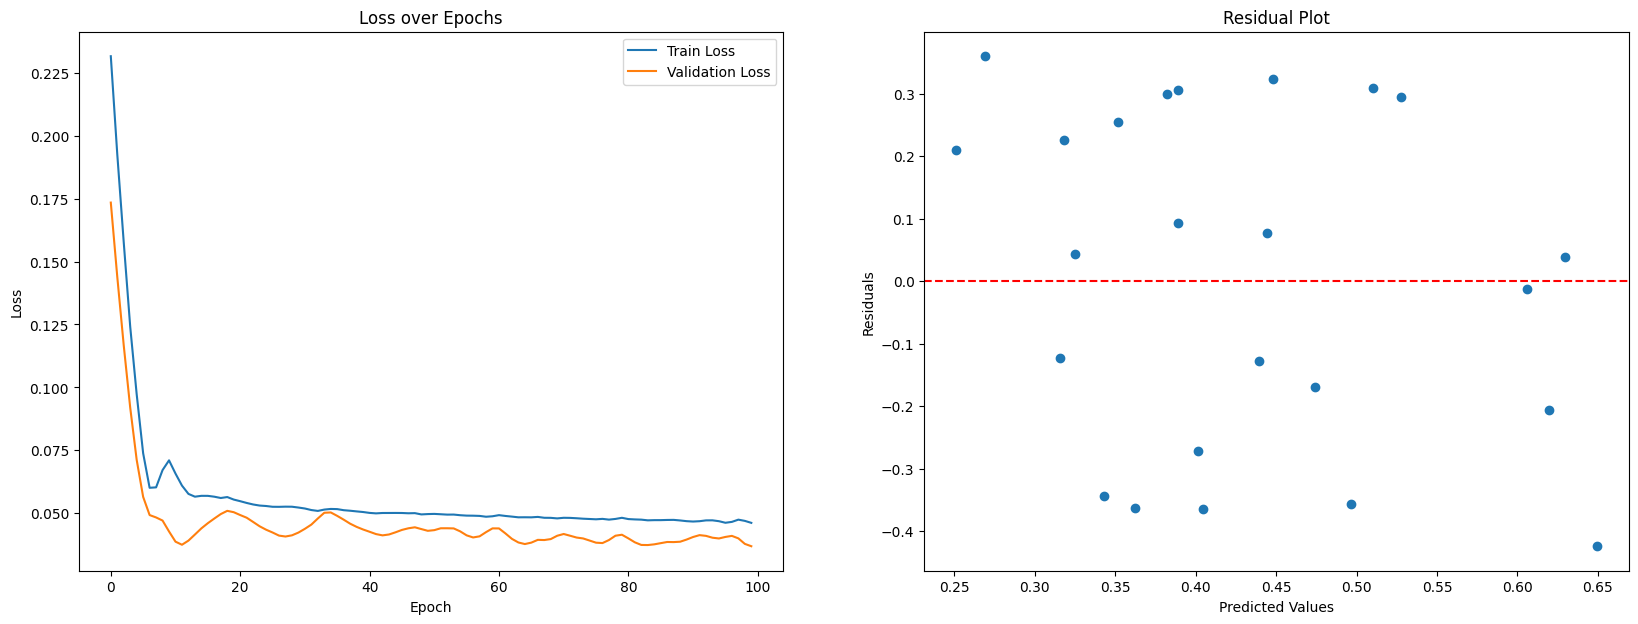

In [15]:
from Data_Prep.createSequence import createSequence
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from joblib import dump


# Load the data from the file system
resampled_df_unclean = pd.read_csv('./Data_Prep/trainData3.csv')
resampled_df = resampled_df_unclean.dropna()

# Define features to scale
features_to_scale = ['Latitude_mean', 'Longitude_mean', 'Bearing_mean', 'Speed_mean']
scaler = MinMaxScaler()
dump(scaler, 'mein_scaler.joblib')

# Fit scaler on data
resampled_df[features_to_scale] = scaler.fit_transform(resampled_df[features_to_scale])

N = 5  # Number of steps to look back

X, y_30, y_60 = createSequence(N, features_to_scale,resampled_df)
# Convert the lists to NumPy arrays
X = np.array(X)
y_30 = np.array(y_30)
y_60 = np.array(y_60)
y = np.column_stack((y_30, y_60))

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train)
print(y_train)

# Define the number of features
n_features = X_train.shape[2]

# Initialize the Sequential model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(N, n_features)))
model.add(LSTM(units=50))
model.add(Dense(units=2))  # Output layer for predicting two targets

# Compile the model
model.compile(optimizer=Adam(), loss='mean_squared_error')

# Fit the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1)
model.save('mein_lstm_modell.h5')


test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')


y_pred = model.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))

ax[0].plot(history.history['loss'], label='Train Loss')
ax[0].plot(history.history['val_loss'], label='Validation Loss')
ax[0].set_title('Loss over Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend()


residuals = y_test - y_pred
ax[1].scatter(y_pred, residuals)
ax[1].set_title('Residual Plot')
ax[1].set_xlabel('Predicted Values')
ax[1].set_ylabel('Residuals')
ax[1].axhline(y=0, color='red', linestyle='--')


plt.show()

